# run_mydataset.py の関数をimportして実行する例

In [1]:
#!git clone https://github.com/rvorias/ind_knn_ad.git
#!rm -r ./output/ind_knn_ad_MyDataset/*

In [2]:
import argparse
import os
import sys
import gc
import glob
import random
import pickle
import traceback
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

from matplotlib import pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings("ignore")

sys.path.append('./ind_knn_ad/indad')
from models import SPADE, PaDiM, PatchCore

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from run_mydataset import (
    # Utils
    get_score,
    init_logger,
    seed_everything,
    find_folders_with_name,
    # Dataset
    get_transforms,
    MyDataset,
    # Model
    save_model,
    load_model,
    inference_loader,
)

In [4]:
# sample_data
def _make_sample_csv(output_dir="."):
    """ind_knn_adのサンプル画像から入力用csv作成"""
    good_paths = sorted(glob.glob(f"./ind_knn_ad/datasets/transistor_reduced/train/good/*"))
    print("len(train):", len(good_paths))
    train = pd.DataFrame({"file_path": good_paths, "label": 0})
    train.to_csv(f"{output_dir}/train.csv", index=False)
    
    good_paths = sorted(glob.glob(f"./ind_knn_ad/datasets/transistor_reduced/test/good/*"))
    defect_paths = []
    for d in ["misplaced", "damaged_case", "cut_lead", "bent_lead"]:
        defect_paths += sorted(glob.glob(f"./ind_knn_ad/datasets/transistor_reduced/test/{d}/*"))
    print("len(valid_good):", len(good_paths))
    print("len(valid_defect):", len(defect_paths))
    valid_good = pd.DataFrame({"file_path": good_paths, "label": 0})
    valid_defect = pd.DataFrame({"file_path": defect_paths, "label": 1})
    valid = pd.concat([valid_good, valid_defect], ignore_index=True)
    valid.to_csv(f"{output_dir}/valid.csv", index=False)

_make_sample_csv(output_dir=".")
input_dir = "../datasets/custom"
output_dir = "./output/import"
os.makedirs(output_dir, exist_ok=True)

len(train): 50
len(valid_good): 2
len(valid_defect): 8


In [5]:
seed_everything(0)

good_paths = sorted(glob.glob(f"{input_dir}/train/good/*"))
print(len(good_paths))
train = pd.DataFrame({"file_path": good_paths, "label": 0})
train.to_csv(f"./train.csv", index=False)
display(train.head())

good_paths = sorted(glob.glob(f"{input_dir}/test/good/*"))
print(len(good_paths))
valid_good = pd.DataFrame({"file_path": good_paths, "label": 0})

defect_paths = sorted(glob.glob(f"{input_dir}/test/defect/*"))
print(len(defect_paths))
valid_defect = pd.DataFrame({"file_path": defect_paths, "label": 1})

valid = pd.concat([valid_good, valid_defect], ignore_index=True)
valid.to_csv(f"./valid.csv", index=False)
display(valid.head())

10


,file_path,label
0,../datasets/custom/train/good/1.png,0
1,../datasets/custom/train/good/10.png,0
2,../datasets/custom/train/good/100.png,0
3,../datasets/custom/train/good/1000.png,0
4,../datasets/custom/train/good/101.png,0


109
10


,file_path,label
0,../datasets/custom/test/good/900.png,0
1,../datasets/custom/test/good/901.png,0
2,../datasets/custom/test/good/902.png,0
3,../datasets/custom/test/good/903.png,0
4,../datasets/custom/test/good/904.png,0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 512, 512]) torch.Size([1])


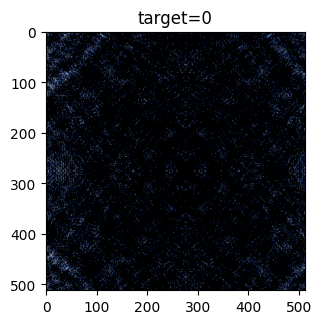

In [6]:
train_loader = DataLoader(MyDataset(train, transforms=get_transforms()))
for step, (images, labels) in enumerate(train_loader):
    print(images.shape, labels.shape)
    plt.figure(figsize=(15,15))
    for i, (im, la) in enumerate(zip(images, labels)):
        im = im.transpose(0, 1).transpose(1, 2)
        plt.subplot(5, 5, i + 1)
        plt.imshow(im)
        plt.title(f"target={la.argmax()}")
        if i > 20:
            break
    plt.tight_layout()
    plt.show()
    break

In [7]:
# model
MODEL_CLS = "SPADE(k=5, backbone_name='wide_resnet50_2')"
#MODEL_CLS = "PaDiM(d_reduced=350, backbone_name='wide_resnet50_2')"  # パラメータファイル超肥大化する + 非常に推論時間かかる
#MODEL_CLS = "PatchCore(f_coreset=.10, backbone_name='wide_resnet50_2')"
model = eval(MODEL_CLS).to(device)

# train
train_loader = DataLoader(MyDataset(train, transforms=get_transforms()))  # bs=1のDataLoader
model.fit(train_loader)
save_model(model, MODEL_CLS, output_dir)

# inference
valid_loader = DataLoader(MyDataset(valid, transforms=get_transforms()))  # bs=1のDataLoader. SPADEではbs増やすとエラーになった
model = load_model(eval(MODEL_CLS), MODEL_CLS, output_dir)
image_preds, pixel_preds = inference_loader(model, valid_loader)

   100%|██████████| 10/10 [00:02<00:00,  4.50it/s]
model load_flg: <All keys matched successfully> ./output/import/model.pth


100%|██████████| 119/119 [00:30<00:00,  3.84it/s]


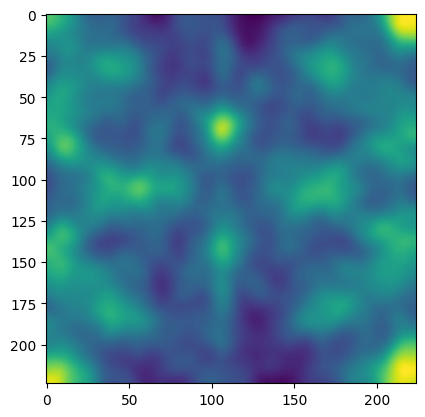

In [8]:
# feature_map
plt.imshow(pixel_preds[0].transpose(1,2,0))
plt.show()

In [9]:
valid["pred"] = image_preds
score = get_score(valid["label"].values, valid["pred"].values)
print("auc:", score)
valid.to_csv(f"{output_dir}/pred.csv", index=False)

auc: 0.5256880733944954


In [10]:
### auc
#- spade_load: 0.5256880733944954
#- spade_no_load: 0.5256880733944954
#- spade_no_load_seed0: 0.5256880733944954
#
#- padim_load: 0.6091743119266055
#- padim_no_load: 0.6981651376146789
#
#- patchcore_load: 0.8770642201834862
#- patchcore_no_load: 0.8733944954128441
#- patchcore_no_load_seed0: 0.8770642201834862

In [11]:
#import timm
#m_list = [
#    "convnextv2_tiny.fcmae_ft_in22k_in1k",
#    "dm_nfnet_f1.dm_in1k",
#    "resnetv2_152x2_bit.goog_in21k_ft_in1k",
#    "convnext_small.fb_in22k_ft_in1k", 
#    "resnext101_32x32d.fb_wsl_ig1b_ft_in1k", 
#    "regnety_160.lion_in12k_ft_in1k", 
#    "tf_efficientnet_b5.ns_jft_in1k", 
#    "resnetv2_152x4_bit.goog_in21k_ft_in1k", 
#    "tf_efficientnet_l2.ns_jft_in1k", 
#    "convnextv2_huge.fcmae_ft_in22k_in1k_384", 
#]
#for backbone_name in m_list:
#    timm.create_model(
#        backbone_name,
#        out_indices=(2,3),
#        features_only=True,
#        pretrained=True,
#    )

In [12]:
#import timm
#from pprint import pprint
#model_names = timm.list_models(pretrained=True)
#pprint(model_names)